## Imports

In [126]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from scipy import signal
#import time #testing de tiempos
from matplotlib import pyplot as plt
from PIL import Image
# import cProfile #testing de tiempos
import itertools
from joblib import Parallel, delayed  #multithreading 

## Definición de funciones

In [140]:
# Definir una red neuronal simple
class Model_qm(nn.Module):
    def __init__(self):
        super(Model_qm, self).__init__()
        self.fc1 = nn.Linear(8, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 8)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [141]:
q_m_XOR = Model_qm()
state_dict_XOR = torch.load('q_m_XOR.pth')
q_m_XOR.load_state_dict(state_dict_XOR)
#input must be tensor with float (each bit)
def q_m_XOR_diff(bits):
    return q_m_XOR(bits)

In [142]:
q_m_XNOR = Model_qm()
state_dict_XNOR = torch.load('q_m_XNOR.pth')
q_m_XNOR.load_state_dict(state_dict_XNOR)
#input must be tensor with float (each bit)
def q_m_XNOR_diff(bits):
    return q_m_XNOR(bits)

In [145]:
#input must be float (each bit)
def q_m_diff(input):
    t_input = torch.tensor(input.copy(),dtype=torch.float32)
    output = torch.tensor([t_input[0], 0, 0, 0, 0, 0, 0, 0, 0],dtype=torch.float32)
    num_1 = torch.sum(t_input > 0.5)
    if (num_1 > 4) or (num_1 == 4 and input[0] == 0):
        output[:8] = q_m_XNOR_diff(t_input)
        output[8] = 0
    else:
        output[:8] = q_m_XOR_diff(t_input)
        output[8] = 1
    return output


In [131]:
#input must be float (each bit) example: [0.0 1.0 1.0 1.0 0.0 0.0 0.0 1.0], 2.0
#output are tensors
def TMDS_diff(pixel_bits,cnt):
    q_m = q_m_diff(pixel_bits[::-1])
   # q_m = torch.tensor(Real2Bit_diff(q_m.detach().numpy()))
    output = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0],dtype=torch.float32)
    num_1 = torch.sum(q_m[:8] > 0.5)
    num_0 = torch.sum(q_m[:8] < 0.5)
    IndE = cnt == 0 or (num_1 == num_0)
    IndC = (cnt > 0 and (num_1 > num_0)) or (cnt < 0 and (num_0 > num_1))
    Neg_q = 1 - q_m
    if (IndE and q_m[8] > 0.5) or (not(IndC) and not(IndE)):
        output[:8] = q_m[:8]
    else:
        output[:8] = Neg_q[:8]
    output[8] = q_m[8]
    if IndE:
        output[9] = Neg_q[8]
        if q_m[8] < 0.5:
            new_cnt = cnt + num_0 - num_1
        else:
            new_cnt = cnt + num_1 - num_0
    else:
        if IndC:
            output[9] = 1
            new_cnt = cnt + 2 * q_m[8] + num_0 - num_1
        else:
            output[9] = 0
            new_cnt = cnt - 2 * Neg_q[8] + num_1 - num_0
    return output,new_cnt

In [132]:
def sigmoid(x):
    if x >= 0:
        return 1 / (1 + np.exp(-x))
    else:
        return np.exp(x) / (1 + np.exp(x))

def Pixel2Bit_diff(pixel):
    output = [0, 0, 0, 0, 0, 0, 0, 0]
    for i in range(1,9):
        output[i-1] = sigmoid(10*(pixel-2**(8-i)+0.5))  # 0.5 para ajustar la sigmoidal
        if pixel >= 2**(8-i):
            pixel = pixel - 2**(8-i)
    return output

In [133]:
#funcion que toma como entrada el armonico a sintonizar y las dimensiones de la imagen a espiar y devuelve un array con taps de g(t)
def g_taps(dim_vertical, dim_horizontal, armonico):

    #defino variables iniciales
    f_b = 10 * (dim_vertical * dim_horizontal * 60)
    f_sdr = 50e6
    harm = armonico * f_b
    
    #para el correcto funcionamiento: dependiendo del armonico, elijo cuantas muestras por pulso
    if (armonico < 5 ):
        muestras_por_pulso  = 10
    else:
        muestras_por_pulso  = 20

    samp_rate = muestras_por_pulso * f_b
    H_samples = dim_horizontal * muestras_por_pulso

    #creo el pulso
    t_continuous = np.linspace(start = 0, stop = H_samples/samp_rate, num = H_samples, endpoint= False)
    pulso = np.zeros(H_samples)
    pulso[:muestras_por_pulso] = 1

    #traslado el espectro del pulso el armonico correspondiente
    frec_armonico = np.exp(-2j*np.pi*harm*t_continuous)
    pulso_complejo = pulso*frec_armonico

    #creo el lpf del sdr
    b, a = signal.butter(6, f_sdr/2, fs=samp_rate, btype='lowpass', analog=False)

    #filtro con lpf el pulso multiplicado por armonico. El resultado es g
    g_t = signal.lfilter(b, a, pulso_complejo)
    g_t = signal.decimate(g_t,q = muestras_por_pulso)

    # si armonico crece, necesito mas taps
    if (armonico < 5):
        g_t = g_t[:170]
    else:
        g_t = g_t[:320]

    g_t_max = np.max(np.abs(g_t))
 
    g_t = g_t / g_t_max

    return torch.tensor(g_t,dtype = torch.complex64).reshape(1,1,len(g_t))

In [134]:
def TMDS_2_row(multiplicador,cant_filas,img,columnas):
    bits_cod_cant_filas = torch.zeros((1,1,10*columnas*cant_filas),dtype = torch.complex64)
    for i in range(multiplicador*cant_filas, cant_filas*(multiplicador+1)):
        cnt = 0
        bits_cod_fila =  torch.zeros(10*columnas,dtype = torch.complex64)
        for j in range(columnas):
            pixel = img[i,j]
            pixel_bits = Pixel2Bit_diff(pixel)
            pixel_cod,cnt = TMDS_diff(pixel_bits, cnt)  
            bits_cod_fila[j*10:(j+1)*10] = pixel_cod
        bits_cod_cant_filas[0,0,(10*columnas)*(i-multiplicador*cant_filas):(10*columnas)*((i-multiplicador*cant_filas)+1)] = bits_cod_fila
    return bits_cod_cant_filas

In [135]:
def encontrar_mayor_divisor(a, b): 
    while b != 0:
        a, b = b, a % b
    return a

def Calc_filas_por_thread(filas, threads):  #calculo la max cantidad de filas para que todos calculen la misma cantidad y no sobren filas, para pasarle a cada hilo de forma de optimizar el uso de los hilos. Pasarle de a pocas filas es ineficiente
    divisor = encontrar_mayor_divisor(filas,threads)
    return filas // divisor

In [136]:
def forward(img, armonico,num_threads):
    filas, columnas = img.shape
    g_t = g_taps(filas, columnas, armonico)
    size_g_t = g_t.numel()    
    padding = (size_g_t - 10)//2
    filas_por_thread = Calc_filas_por_thread(filas,num_threads)
    result = Parallel(n_jobs=num_threads)(delayed(TMDS_2_row)(multiplicador,filas_por_thread,img,columnas) for multiplicador in range(num_threads)) # da mejores resultados por poquito el multiprocessing (Pool)
    #(result es una lista, no un tensor de torch)
    if num_threads == 1:
        bits_TMDS = result[0]
    else:
        bits_TMDS = result[0]
        for i in range(1, len(result)):
            bits_TMDS = torch.cat((bits_TMDS, result[i]), dim = 2)
    img_salida = nn.functional.conv1d(bits_TMDS, g_t, stride = 10, padding=padding, bias = None)[0,0,:].reshape((filas,columnas))
    return img_salida

In [139]:
image_path = '../VAMO!!.png'
img = np.asarray(Image.open(image_path))[:,:,0] #solo canal rojo
armonico = 3
num_threads = 10  # elegir numeros de hilos del cpu (dejar alguno libre para que no explote la PC)
#cProfile.runctx('forward(imag,armonico)', globals(), locals()) 
imagen = forward(img, armonico,num_threads)

## Checking trained TMDS coding is equal to original coding

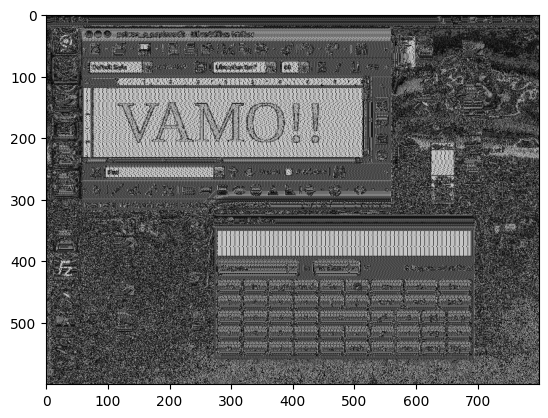

In [ ]:
img_sim = np.abs(imagen.detach().numpy())
img_sim = 255*((img_sim - img_sim.min())/(img_sim.max()-img_sim.min()))
plt.figure()
plt.imshow(img_sim,cmap='gray')
plt.show()


In [ ]:
im = Image.fromarray(img_sim.astype('uint8'))
im.save('../../images/vamo.png')


In [ ]:
def uint8_to_binarray(integer):
  """Convert integer into fixed-length 8-bit binary array. LSB in [0].
  Extended and modified code from https://github.com/projf/display_controller/blob/master/model/tmds.py
  """

  b_array = [int(i) for i in reversed(bin(integer)[2:])]
  b_array += [0]*(8-len(b_array))
  return b_array


def binarray_to_uint(binarray):
	
  array = binarray[::-1]
  num = array[0]
  for n in range(1,len(binarray)):
    num = (num << 1) + array[n]

  return num

def TMDS_pixel (D,cnt=0):
  """8bit pixel TMDS coding

  Inputs: 
  - pix: 8-bit pixel
  - cnt: 0's and 1's balance. Default in 0 (balanced)

  Outputs:
  - pix_out: TDMS coded 16-bit pixel (only 10 useful)
  - cnt: 0's and 1's balance updated with new pixel coding

  """ 
  # Convert 8-bit pixel to binary list D
  #D = uint8_to_binarray(pix)

  # Initialize output q
  qm = [D[0]]

  # 1's unbalanced condition at current pixel
  N1_D = np.sum(D)

  if N1_D>4 or (N1_D==4 and not(D[0])):

    # XNOR of consecutive bits
    for k in range(1,8):
      qm.append( not(qm[k-1] ^ D[k]) )
    qm.append(0)

  else:
    # XOR of consecutive bits
    for k in range(1,8):
      qm.append( qm[k-1] ^ D[k] )
    qm.append(1)

  # Initialize output qout
  qout = qm.copy()

  # Unbalanced condition with previous and current pixels
  N1_qm = np.sum(qm[:8])
  N0_qm = 8 - N1_qm

  if cnt==0 or N1_qm==4:

    qout.append(not(qm[8]))
    qout[8] = qm[8]
    qout[:8]=qm[:8] if qm[8] else np.logical_not(qm[:8])

    if not(qm[8]):
      cnt += N0_qm - N1_qm 
    else:
      cnt += N1_qm - N0_qm 

  else:

    if (cnt>0 and N1_qm>4) or (cnt<0 and N1_qm<4):
      qout.append(1)
      qout[8] = qm[8]
      qout[:8] = np.logical_not(qm[:8])
      cnt += 2*qm[8] + N0_qm - N1_qm
    else:
      qout.append(0)
      qout[8] = qm[8]
      qout[:8] = qm[:8]
      cnt += -2*(not(qm[8])) + N1_qm - N0_qm

  return qout, cnt


In [ ]:
enteros = range(-9, 10)
binarios = [list(map(int, list(bin(i)[2:].zfill(8)))) for i in range(256)]

combinaciones = list(itertools.product(binarios, enteros))

X = np.array([list(comb[0]) + [comb[1]] for comb in combinaciones])
X_float = X.astype(float)

print(X)
print(X_float)
print(X.shape)

[[ 0  0  0 ...  0  0 -9]
 [ 0  0  0 ...  0  0 -8]
 [ 0  0  0 ...  0  0 -7]
 ...
 [ 1  1  1 ...  1  1  7]
 [ 1  1  1 ...  1  1  8]
 [ 1  1  1 ...  1  1  9]]
[[ 0.  0.  0. ...  0.  0. -9.]
 [ 0.  0.  0. ...  0.  0. -8.]
 [ 0.  0.  0. ...  0.  0. -7.]
 ...
 [ 1.  1.  1. ...  1.  1.  7.]
 [ 1.  1.  1. ...  1.  1.  8.]
 [ 1.  1.  1. ...  1.  1.  9.]]
(4864, 9)


In [ ]:
errores = 0
for i in range(X.shape[0]):
    bits_diff,cnt_diff = TMDS_diff(X_float[i,:8],X_float[i,8])
    bits_posta,cnt_posta = TMDS_pixel(X[i,:8][::-1],X[i,8])
    bits_posta = np.array(bits_posta)
    if not(np.array_equal(np.round(bits_diff.detach().numpy()), bits_posta[:10])) and cnt_posta != np.round(cnt_diff.detach().numpy()):
        errores = errores + 1
        print(f"input: {X[i,:8]} cnt:{X[i,8]}")
        print(f"diff:{np.round(bits_diff.detach().numpy())} cnt diff:{cnt_diff.detach().numpy()}")
        print(f"posta:{bits_posta},cnt:{cnt_posta}")
        print(f"\n\n")
print(errores)

0
